<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/usage_example(colab)V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!git clone https://github.com/skywalker0803r/c620.git
!pip install autorch > log.txt
!pip install optuna > log.txt

Cloning into 'c620'...
remote: Enumerating objects: 2259, done.
remote: Counting objects: 100% (1077/1077), done.
remote: Compressing objects: 100% (619/619), done.
remote: Total 2259 (delta 702), reused 687 (delta 449), pack-reused 1182
Receiving objects: 100% (2259/2259), 59.86 MiB | 18.44 MiB/s, done.
Resolving deltas: 100% (1480/1480), done.


# import

In [26]:
from c620.FV2 import AllSystem
from c620.configV2 import config
import joblib
import numpy as np
import pandas as pd
import os
os.chdir('/content/c620')
print(os.getcwd())
!git pull

/content/c620
Already up to date.


# demo data

In [27]:
demo = joblib.load('./data/demo.pkl')
print(demo.keys())
icg_input = demo['icg_input']
c620_feed = demo['c620_feed']
t651_feed = demo['t651_feed']
icg_input.head()

dict_keys(['icg_input', 'c620_feed', 't651_feed', 'c620_op', 'c620_wt', 'c660_op', 'c660_wt', 'c670_op', 'c670_wt'])


,Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr,Simulation Case Conditions_Feed Rate_Feed from V615 Btm NA_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr,Simulation Case Conditions_Feed Rate_Feed from C820 Dist NA_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr,Simulation Case Conditions_Feed Rate_Feed from T651 NA_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Toluene_wt%,Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%,Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw,Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC
137-026,188.0,1.116023,11.152225,48.745979,15.0,2.338977,74.302254,17.467825,77.0,0.0911,20.854397,74.689774,70.0,920.0,0.01,10.000004,36.0


# 這一筆樣本的NA in Benzene_ppmw只有920 期望能拉到 980

In [28]:
icg_input[['Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw']]

,Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw
137-026,920.0


In [29]:
icg_input[['Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%']]

,Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%
137-026,70.0


In [30]:
icg_input[['Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw']]

,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw
137-026,10.000004


# 1.試算模式

In [31]:
f = joblib.load('/content/c620/model/allsystem.pkl')

In [32]:
demo['icg_input']

,Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr,Simulation Case Conditions_Feed Rate_Feed from V615 Btm NA_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr,Simulation Case Conditions_Feed Rate_Feed from C820 Dist NA_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr,Simulation Case Conditions_Feed Rate_Feed from T651 NA_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Toluene_wt%,Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%,Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw,Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC
137-026,188.0,1.116023,11.152225,48.745979,15.0,2.338977,74.302254,17.467825,77.0,0.0911,20.854397,74.689774,70.0,920.0,0.01,10.000004,36.0


In [33]:
c620_wt,c620_op,c660_wt,c660_op,c670_wt,c670_op = f.inference(demo['icg_input'],demo['c620_feed'],demo['t651_feed'])

# 檢查三項

In [34]:
c620_wt[['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%']]

,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%
137-026,69.024115


In [35]:
na_idx = [1,2,3,4,5,6,8,9,11,13,14,15,20,22,29] 
c660_wt.filter(regex='Side').filter(regex='wt%').iloc[:,na_idx].sum(axis=1).values[0]*10000

924.8630486975103

In [36]:
c660_wt['Benzene Column C660 Operation_Sidedraw (Benzene )Production Rate and Composition_Toluene_wt%'].values[0]*10000

7.856721733271881

In [37]:
c620_wt.iloc[:,:41].sum(axis=1)

137-026    100.0
dtype: float64

In [38]:
c660_wt.iloc[:,:41].sum(axis=1)

137-026    100.0
dtype: float64

In [39]:
c670_wt.iloc[:,:41].sum(axis=1)

137-026    100.0
dtype: float64

# 推薦模式

In [40]:
c620_wt2,c620_op2,c660_wt2,c660_op2,c670_wt2,c670_op2,bz_error,nainbz_error,tol_error = f.recommend(demo['icg_input'],demo['c620_feed'],demo['t651_feed'],auto_set_x0=True)

[I 2021-04-27 06:15:19,150] A new study created in memory with name: no-name-adbdfd7a-af83-4a78-a50f-7f748352b89b
[I 2021-04-27 06:15:19,236] Trial 0 finished with value: 1.0525816374963186 and parameters: {'Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC': 176.45894546688135, 'Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC': 194.06694596340526, 'Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr': 6.917336352405294}. Best is trial 0 with value: 1.0525816374963186.
[I 2021-04-27 06:15:19,325] Trial 1 finished with value: 1.0214874401903358 and parameters: {'Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC': 178.00296468082954, 'Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC': 192.9251885191862, 'Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr': 0.1444821297868537}. Best is trial 1 with value: 1.0214874401903358

bz_error: 8.346506260181741e-05
nainbz_error: 29.222046049105757
tol_error: 8.900583372550841e-06


# 計算delta調幅

In [41]:
(c620_op2-c620_op).iloc[:,-2:]

,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
137-026,-0.097854,-0.092828


In [42]:
(c660_op2-c660_op).iloc[:,-2:]

,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC
137-026,0.008864,-0.058913


In [43]:
(c670_op2-c670_op).iloc[:,-2:]

,Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC
137-026,0.023132,0.052505


# 檢查Sidedraw Production Rate and Composition_Benzene是否等於70

In [44]:
c620_wt2[['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%']]

,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%
137-026,70.000083


# 從原本的920 提高到了 950! 雖然離980有些距離 但是也拉高了30

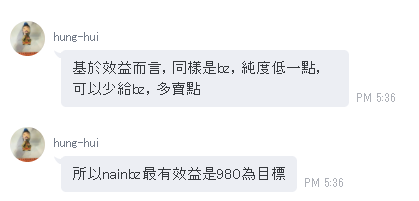

In [47]:
na_idx = [1,2,3,4,5,6,8,9,11,13,14,15,20,22,29] 
c660_wt2.filter(regex='Side').filter(regex='wt%').iloc[:,na_idx].sum(axis=1).values[0]*10000

950.7779539508942

# 檢查 TOL 是否等於10

In [48]:
c660_wt2['Benzene Column C660 Operation_Sidedraw (Benzene )Production Rate and Composition_Toluene_wt%'].values[0]*10000

9.999991099416627